In [ ]:
# NSL-KDD Anomaly Detection with Isolation Forest

#My takeaways

# This notebook demonstrates anomaly detection on the NSL-KDD dataset, a benchmark dataset
# for network intrusion detection.

# I downloaded it from Hugging face

# The dataset contains network traffic records, each with 41 features (e.g. `duration`,
# `protocol_type`, `service`, `flag`, `src_bytes`, `dst_bytes`, etc.) and a label indicating
# whether the connection is normal or an attack.

# Attack categories include:
# - DoS / DDoS (Denial of Service)** → flooding a network with traffic
# - Probe → scanning to gather information
# - R2L (Remote to Local)** → unauthorized access from a remote machine
# - U2R (User to Root)** → privilege escalation attacks

# ### Columns (examples):
# - duration → length of the connection
# - protocol_type` → type of protocol (TCP, UDP, ICMP)
# - service → network service (HTTP, FTP, SMTP, etc.)
# - flag → status flag of the connection
# - src_bytes, dst_bytes → number of bytes sent/received
# - label → normal or the type of attack

# ### Goal
# We apply the **Isolation Forest** algorithm (an unsupervised anomaly detection method)
# to identify malicious connections (attacks) in the dataset.

# Even though Isolation Forest is unsupervised, the labels in NSL-KDD allow us to
# evaluate the model’s accuracy in detecting anomalies (attacks). Making it semi-supervised

#afterall goal of isolation tree is to ostracize every data point in a leaf if we keep slpittting Long enough

In [ ]:
!pip install datasets

from datasets import load_dataset
import pandas as pd

# Loading   NSL-KDD dataset from Hugging Face
dataset = load_dataset("Mireu-Lab/NSL-KDD")

# Converting splits to pandas DataFrames
df_train = pd.DataFrame(dataset["train"])
df_test = pd.DataFrame(dataset["test"])



In [ ]:

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

In [ ]:
df_train.head()

In [ ]:
#Again please note
# Even though Isolation Forest is unsupervised, the labels in NSL-KDD allow us to
# evaluate the model’s accuracy in detecting anomalies (attacks).Classs are normal anmd  anomaly or attack

In [ ]:
#importing more necessary packages
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import make_pipeline
import joblib
import os

In [ ]:
LABEL_COL = "class"



# Spliting my  features and target in training dataset
X_train_raw = df_train.drop(columns=[LABEL_COL])
y_train_raw = df_train[LABEL_COL]

In [ ]:
mask_norm = y_train_raw == "normal"

X_train_raw = X_train_raw[mask_norm]

#My X train should only be trained on normal pts .Then only when it sees an anomalous
# pt in Y test it will quickly split  it out

In [ ]:
# Spliting my  features and target in testing  dataset
X_test_raw = df_test.drop(columns=[LABEL_COL])

label_map = {"normal": 0, "anomaly": 1}

# Apply mapping to create y_test
y_test = df_test[LABEL_COL].map(label_map).values


In [ ]:
#Preprocessing and segregating my numerical and categorical columns
categorical_cols = ["protocol_type", "service", "flag"]
numeric_cols = [c for c in X_train_raw.columns if c not in categorical_cols] # running a for loop

In [ ]:
ct = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),#applying on hot encoding to avoid mutlicolinerity trap to cat_columns
        ("scale", StandardScaler(), numeric_cols),  # scalinmg numerical columns
    ]
)

#ColumnTransformer from scikit-learn lets us apply different preprocessing to different feature types in a single pipeline.
#The parameter handle_unknown="ignore" ensures the model won’t crash if the test set introduces a category not seen during training (e.g., icmp showing up only in test).
# We also set sparse=False so that the encoder returns a dense array instead of a sparse matrix,give all 0 and 1
# which makes it easier to combine with scaled numeric features before training the Isolation Forest.


In [ ]:
# transforming my X train raw and X test raw

X_train = ct.fit_transform(X_train_raw)
X_test  = ct.transform(X_test_raw)

print("Transformed train shape:", X_train.shape)
print("Transformed test shape:", X_test.shape)

**ISOLATION FOREST **

---



In [ ]:
###training my isolation forest model -

#Susnata's Isolation forest we will find out those anomalies :V

from sklearn.ensemble import IsolationForest

susnata_iso = IsolationForest(
    n_estimators=200,        # number of trees in the forest (more trees = more stable but slower)
    max_samples=256,         # number of data points sampled to build each tree
    contamination=0.28,    # threshold for anomalies set to "auto" because y_test.mean() can exceed 0.5 and isolation
                              #Forest it supports upto0.5.From auto i tried tweaking it to see what give me best recall for positive fraud class

    max_features=1.0,        # fraction of features used at each split 1.0 = use all features
    bootstrap=False,         # whether to sample data points with replacement (default = False)like boostrap aggrgation In RF
    n_jobs=-1,               # use all CPU cores for faster training
    random_state=42          # for reproducibility of results
)

susnata_iso.fit(X_train)  # fitting only on "normal" data

In [ ]:
# Predicting  on test data that has both normal and anomalous

# if we see the anomaly score formula pts which are 1 is anomalous 0.5 is boderline and 0 is normal

#hence reverse mapping accordingly

pred_map = {-1: 1, 1: 0}   # -1 = anomaly, 1 = normal
y_pred = pd.Series(susnata_iso.predict(X_test)).map(pred_map).values


In [24]:
# Evaluating
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))



Confusion Matrix:
 [[ 8492  3371]
 [ 2408 20123]]

Classification Report:
               precision    recall  f1-score   support

           0     0.7791    0.7158    0.7461     11863
           1     0.8565    0.8931    0.8744     22531

    accuracy                         0.8320     34394
   macro avg     0.8178    0.8045    0.8103     34394
weighted avg     0.8298    0.8320    0.8302     34394



In [ ]:
#My Takeaways

### Confusion Matrix Explanation
# - TN (8492): Normal traffic correctly identified as normal.
# - FP (3371): Normal traffic incorrectly flagged as an attack (false alarms).
# - FN (2408): Attacks that were missed and classified as normal.
# - TP (20123): Attacks correctly identified as attacks.

# This gives:
# - Precision (Anomalies) ≈ 0.856 → when the model flags an attack, it’s correct 85% of the time.
# - Recall (Anomalies) ≈ 0.893 → the model catches ~89% of all attacks.

#  In anomaly detection, **recall is critical** (we don’t want to miss attacks).
#  Here, the model achieves **high recall with good precision**, making it effective for intrusion detection.

In [25]:
scores = -susnata_iso.decision_function(X_test)
roc = roc_auc_score(y_test, scores)
print(f"\nROC AUC: {roc:.4f}")


ROC AUC: 0.9009


In [ ]:
### Evaluating Model with ROC AUC

# - I am using -decision_function

#   The Isolation Forest’s decision_function assigns **positive scores to normal points** and **negative scores to anomalies**.
#   Since we want higher scores = higher anomaly likelihood (for evaluation consistency), we negate the output.
#   This ensures that anomalies get higher scores, which aligns with ROC AUC and other anomaly detection metrics.


#   ROC AUC measures the model’s ability to rank anomalies higher than normal traffic, independent of the classification threshold.
#   - 0.5 = random guessing
#   - 1.0 = perfect ranking
#   In our case, **ROC AUC = 0.9009**, showing the model is very effective at distinguishing anomalies from normal traffic.


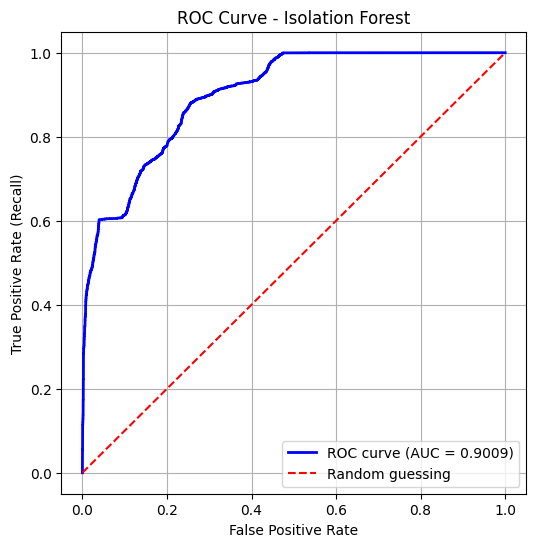

In [23]:
#Visualizing auc roc curve


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Using  flipped decision scores
scores = -susnata_iso.decision_function(X_test)

# Computing ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Isolation Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
import joblib

from google.colab import files

# Saving the trained model
joblib.dump(susnata_iso, "isolation_forest_model.joblib")

# Downloading in  my  local machine
files.download("isolation_forest_model.joblib")


# Loading it later
# loaded_iso = joblib.load("isolation_forest_model.joblib")

#If i want to reuse the model later
# y_loaded_pred = loaded_iso.predict(X_test)

My Isolation Forest achieved ~0.9 AUC and ~0.89 recall for fraud detection, meaning it detects ~9 out of 10 attacks while keeping false positives under control.”